## Final challenge: Kiwi inspection

In this last part I tried to identify from a group of images with healthy kiwis the one that presents defects, this in a more realistic environment since much more noise can be observed in the background which can alter our response, so the image preprocessing is crucial to obtain the desired results. So, let's start by reading all the images.

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import utils

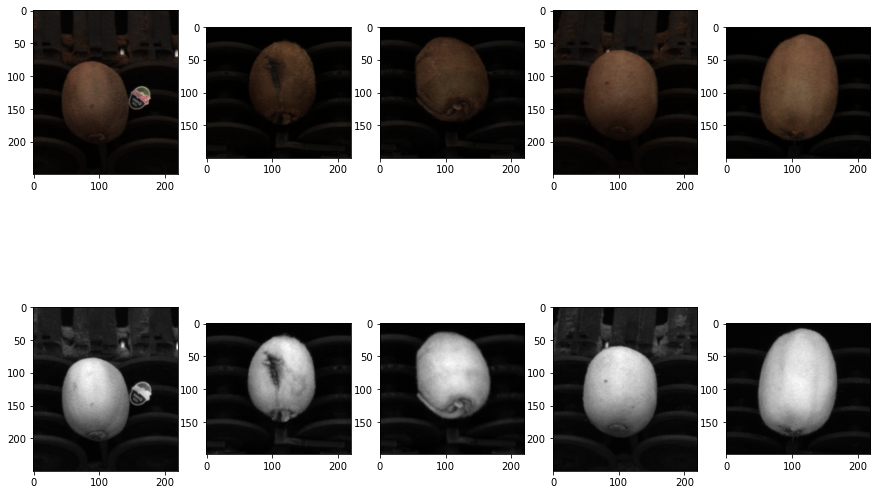

In [3]:
# Directorio de las imágenes
img_directory = 'fruit-inspection-images/final challenge/'

# Obtener una lista de nombres de archivo en el directorio
file_names = [file for file in os.listdir(img_directory) if os.path.isfile(os.path.join(img_directory, file))]

# Filtrar imágenes a color (C1) y blanco y negro (C0)
color_images = [cv.imread(os.path.join(img_directory, file), cv.IMREAD_COLOR) for file in file_names if 'C1_' in file]
gray_images = [cv.imread(os.path.join(img_directory, file), cv.IMREAD_GRAYSCALE) for file in file_names if 'C0_' in file]

# Verificar si las imágenes se cargaron correctamente
assert all(image is not None for image in color_images), "Error al leer las imágenes en color"
assert all(image is not None for image in gray_images), "Error al leer las imágenes en blanco y negro"

# Mostrar las imágenes utilizando matplotlib
utils.show_image(color_images, gray_images)

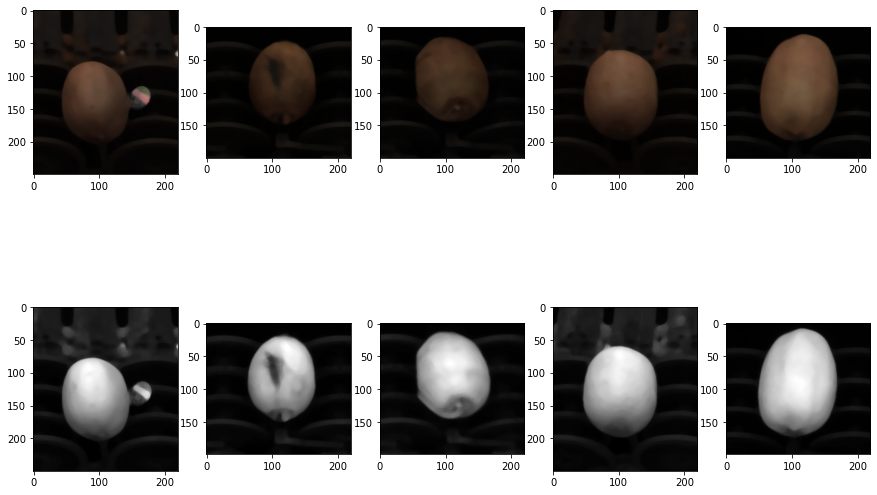

In [4]:
# Aplicar desenfoque para reducir el ruido
gray_images = [cv.medianBlur(img, 9) for img in gray_images]
color_images = [cv.medianBlur(img, 9) for img in color_images]

# Mostrar las imágenes utilizando matplotlib
utils.show_image(color_images, gray_images)

We directly apply the blur to eliminate the noise and then know the appropriate threshold value for binarization to obtain the appropriate mask.

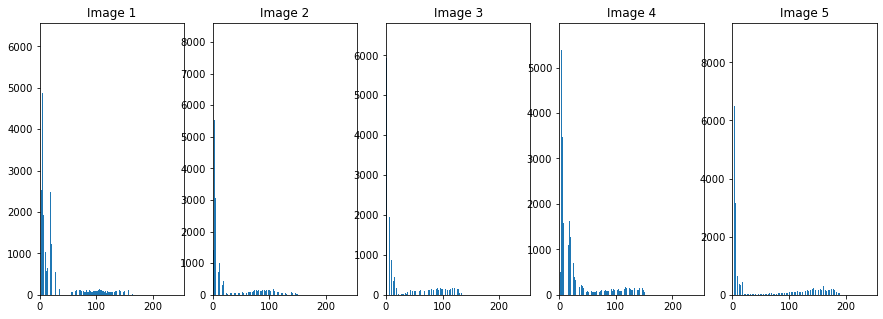

In [5]:
plt.figure(figsize=(15, 5))

for i, img in enumerate(gray_images):
    vals = img.flatten()
    plt.subplot(1,len(gray_images),i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

plt.show()

As with the previous examples, we did not obtain a correct performance using the Otsu algorithm, so we chose the threshold value by observing the histogram, in this case we chose the value of 70. However, as can be seen in the image, the label present in the first image affects the performance of our algorithm, so it is essential to eliminate it, however, increasing the threshold value in this example is not enough. 

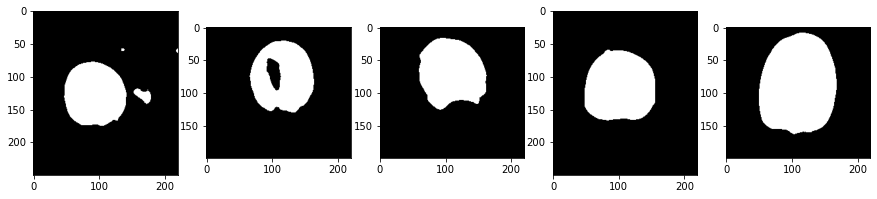

In [6]:
# Umbralizar la imagen
masks = []
i = 0;
for img in gray_images:
    ret, th1 = cv.threshold(img, 70, 255, cv.THRESH_BINARY)
    masks.append(th1)
    

utils.show_gray_image(masks)

Therefore, the morphological opening operation was used, which combines two basic operations, erosion followed by dilation, and which is quite useful to eliminate the noise generated by small objects such as in our case generated by the label. The kernel value had to be set to a high value (17x18) since the identified tag was quite large. The opening is denoted by:
$(A)=(A⊖B)⊕B$
where
* $A$ is the input image and
* $B$ is the structuring element.

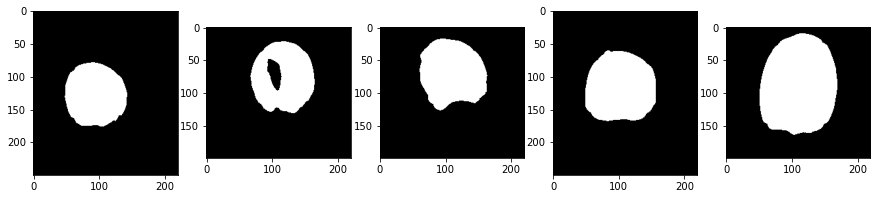

In [7]:
masks_final = []

for img in masks:
    kernel = cv.getStructuringElement(cv.MORPH_CROSS, (18, 18))
    opening = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    masks_final.append(opening)

utils.show_gray_image(masks_final)

Finally, all that remains is to highlight the edges of the image, again using the findcountours and drawcountours functions without taking into account the largest edge that encloses the inside edges. Then, to know if the kiwi is damaged, I counted the edges inside the big on. If there is another edge it means that it has an imperfection and if it does not, it means that the kiwi is in perfect condition.

The kiwi  2  has an imperfection


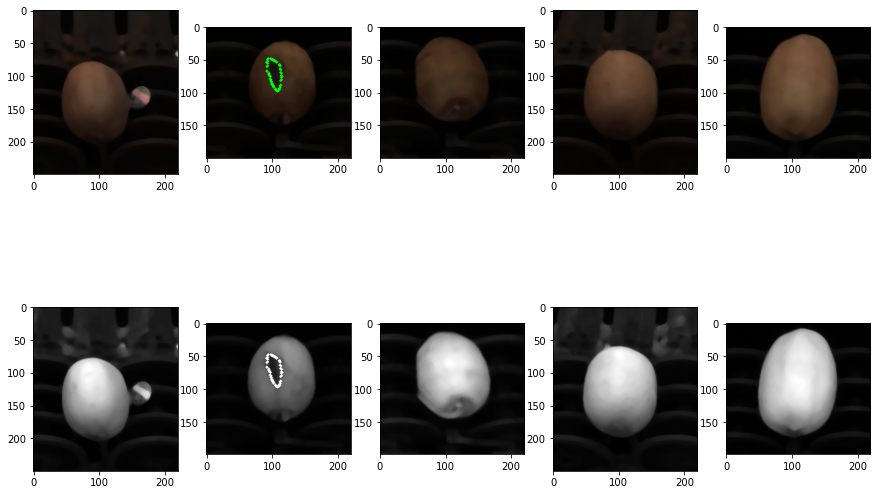

In [10]:
final_c = []
final_bn = []

for i, bordes in enumerate(masks_final):
    final_contornos,_= cv.findContours(bordes, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    # Filtrar los contornos para obtener solo los contornos internos
    if len(final_contornos) > 1:
        print("The kiwi ", i+1, " has an imperfection")
        final_c.append(cv.drawContours(color_images[i], final_contornos[1], -1, (0, 255, 0), 3))
        final_bn.append(cv.drawContours(gray_images[i], final_contornos[1], -1, 255, 3))
    else:
        final_c.append(color_images[i])
        final_bn.append(gray_images[i])
    

utils.show_image(final_c,final_bn)